# Random Forest for NEK 9 Dataset
## Chongye Feng
### Binding

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import logging
import pandas as pd
import numpy as np
import imblearn as imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from rdkit import Chem
from rdkit.Chem import Draw
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from atom2024 import utils
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

In [2]:
smile_prop_df = pd.read_csv('../../../data/NEK_data_4Berkeley/NEK9/NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold5'].drop(columns=['fold'])

mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))

[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalDisconnector
[13:24:22] Initializing Normalizer
[13:24:22] Running Normalizer
[13:24:22] Running LargestFragmentChooser
[13:24:22] Running Uncharger
[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalDisconnector
[13:24:22] Initializing Normalizer
[13:24:22] Running Normalizer
[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalDisconnector
[13:24:22] Initializing Normalizer
[13:24:22] Running Normalizer
[13:24:22] Running LargestFragmentChooser
[13:24:22] Running Uncharger
[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalDisconnector
[13:24:22] Initializing Normalizer
[13:24:22] Running Normalizer
[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalDisconnector
[13:24:22] Initializing Normalizer
[13:24:22] Running Normalizer
[13:24:22] Running LargestFragmentChooser
[13:24:22] Running Uncharger
[13:24:22] Initializing MetalDisconnector
[13:24:22] Running MetalD

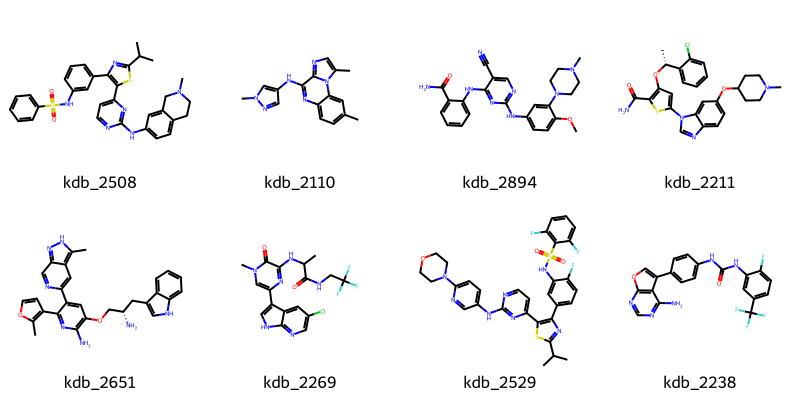

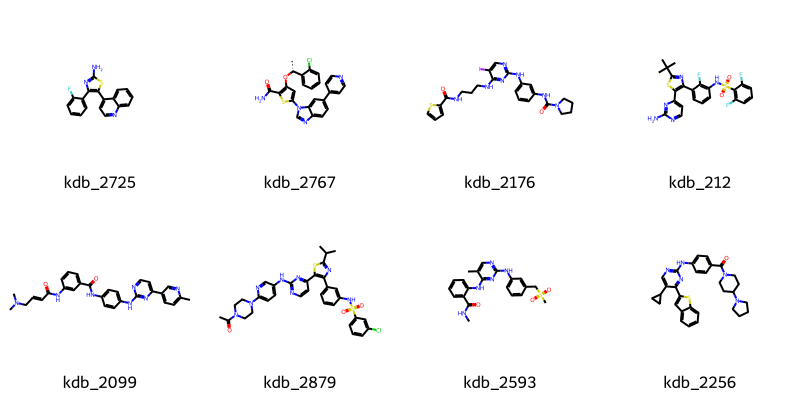

In [3]:
active_train = []

for m in mol_train:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_train.append(m)

display(Draw.MolsToGridImage(active_train[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train[:8]]))

active_test = []
for m in mol_test:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_test.append(m)

display(Draw.MolsToGridImage(active_test[:8],molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test[:8]]))

In [4]:
with Chem.SDWriter('../../../data/NEK_data_4Berkeley/NEK9/NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf') as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter('../../../data/NEK_data_4Berkeley/NEK9/NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf') as writer:
    for m in mol_test:
        writer.write(m)

In [5]:
X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)

In [6]:
def rf_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix

/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9572953736654805


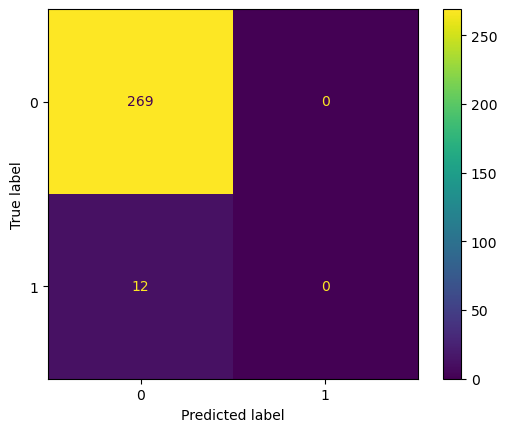

In [7]:
accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy: 0.9750889679715302


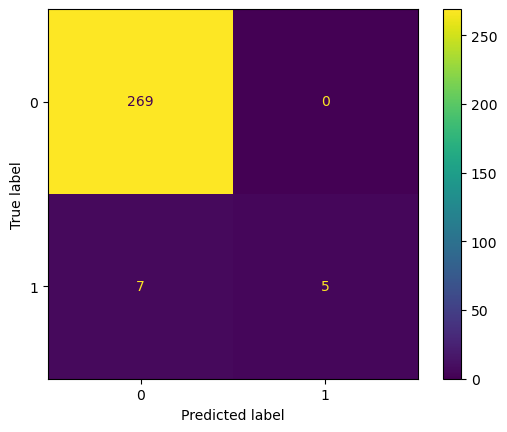

In [8]:
accuracy, precision, recall, conf_matrix = rf_model(X_morgan_train, y_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy: 0.9608540925266904


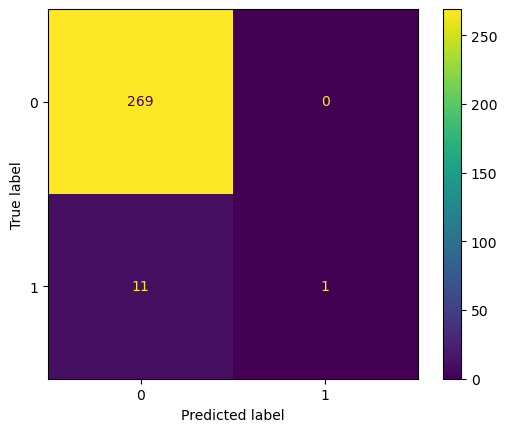

In [9]:
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy: 0.9572953736654805


/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


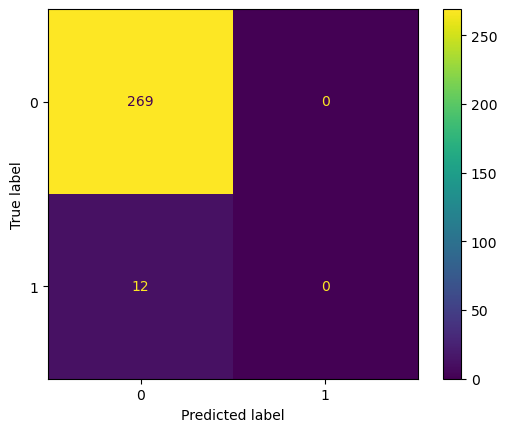

In [10]:
# SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_smote, y_smote, X_existing_test, y_test)

print("Accuracy:", accuracy)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();